Quoting these notes,

In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


In [ ]:

from google.colab import drive
drive.mount('/content/gdrive')

PATH_OF_DATA= '/content/gdrive/"My Drive"/ooredoo_cnn'
!ls {PATH_OF_DATA}

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
test  test_1  train  val


In [ ]:



from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode
import torch
import os 
import torchvision
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.transforms as transforms

Load Data

In [ ]:
# Comment 0: define transformation that you wish to apply on image
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [ ]:
data_dir = '/content/gdrive/My Drive/ooredoo_cnn'
image_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



Visualize a few images

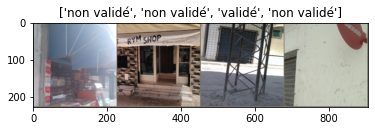

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

These two major transfer learning scenarios look as follows:

Finetuning the convnet: Instead of random initializaion, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.
ConvNet as fixed feature extractor: Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7813 Acc: 0.6181
val Loss: 0.6051 Acc: 0.6588

Epoch 1/24
----------
train Loss: 0.7320 Acc: 0.6374
val Loss: 0.5617 Acc: 0.6775

Epoch 2/24
----------
train Loss: 0.7610 Acc: 0.6392
val Loss: 1.8139 Acc: 0.2363

Epoch 3/24
----------
train Loss: 0.7404 Acc: 0.6401
val Loss: 0.4457 Acc: 0.7900

Epoch 4/24
----------
train Loss: 0.7964 Acc: 0.6438
val Loss: 0.6476 Acc: 0.6238

Epoch 5/24
----------
train Loss: 0.7038 Acc: 0.6566
val Loss: 0.5273 Acc: 0.7050

Epoch 6/24
----------
train Loss: 0.7056 Acc: 0.6584
val Loss: 0.4186 Acc: 0.8100

Epoch 7/24
----------
train Loss: 0.5816 Acc: 0.7353
val Loss: 0.4207 Acc: 0.8125

Epoch 8/24
----------
train Loss: 0.5374 Acc: 0.7216
val Loss: 0.4624 Acc: 0.7775

Epoch 9/24
----------
train Loss: 0.5438 Acc: 0.7353
val Loss: 0.4116 Acc: 0.8125

Epoch 10/24
----------
train Loss: 0.5486 Acc: 0.7143
val Loss: 0.3872 Acc: 0.8413

Epoch 11/24
----------
train Loss: 0.5380 Acc: 0.7418
val Loss: 0.4441 Acc: 0.7988

Ep

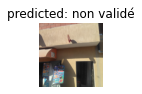

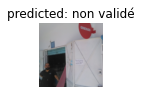

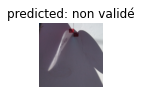

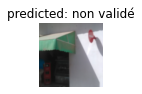

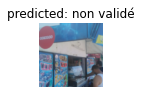

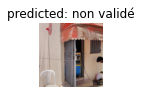

In [ ]:
visualize_model(model_ft)

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8010 Acc: 0.6273
val Loss: 0.6716 Acc: 0.6200

Epoch 1/24
----------
train Loss: 0.7554 Acc: 0.6346
val Loss: 0.5352 Acc: 0.7338

Epoch 2/24
----------
train Loss: 0.7201 Acc: 0.6438
val Loss: 0.5354 Acc: 0.7775

Epoch 3/24
----------
train Loss: 0.8245 Acc: 0.6374
val Loss: 0.5477 Acc: 0.7288

Epoch 4/24
----------
train Loss: 0.7035 Acc: 0.6346
val Loss: 0.5265 Acc: 0.7288

Epoch 5/24
----------
train Loss: 0.7218 Acc: 0.6511
val Loss: 0.6767 Acc: 0.6325

Epoch 6/24
----------
train Loss: 0.7597 Acc: 0.6438
val Loss: 0.7256 Acc: 0.6188

Epoch 7/24
----------
train Loss: 0.5924 Acc: 0.6804
val Loss: 0.5143 Acc: 0.7350

Epoch 8/24
----------
train Loss: 0.6233 Acc: 0.6896
val Loss: 0.4804 Acc: 0.7650

Epoch 9/24
----------
train Loss: 0.6002 Acc: 0.6914
val Loss: 0.5320 Acc: 0.7225

Epoch 10/24
----------
train Loss: 0.5833 Acc: 0.7060
val Loss: 0.5087 Acc: 0.7500

Epoch 11/24
----------
train Loss: 0.5902 Acc: 0.6886
val Loss: 0.5439 Acc: 0.7250

Ep

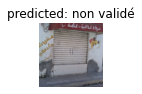

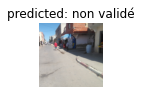

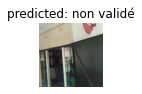

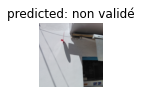

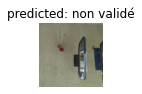

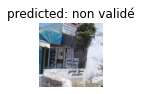

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [ ]:
!mkdir models
!mkdir models/pytorch
torch.save(model_ft.state_dict(), '/content/gdrive/My Drive/ooredoo_cnn/models/pytorch/weights.h5')

In [ ]:
from PIL import Image
import time
from torch.autograd import Variable
import json
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import PIL
from PIL import Image
from collections import OrderedDict
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F


image_path = '/content/gdrive/My Drive/ooredoo_cnn/val/validé/Ramzi baccouchi id 561.jpg'
img = Image.open(image_path)

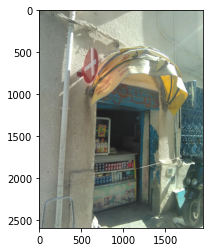

In [ ]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # TODO: Process a PIL image for use in a PyTorch model
    # tensor.numpy().transpose(1, 2, 0)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])
    image = preprocess(image)
    return image
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax
with Image.open(image_path) as image:
    plt.imshow(image)
model_ft.class_to_idx = image_datasets['train'].class_to_idx

In [ ]:
def predict2(image_path, model, topk=2):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    img = Image.open(image_path)
    img = process_image(img)
    
    # Convert 2D image to 1D vector
    img = np.expand_dims(img, 0)
    
    
    img = torch.from_numpy(img)
    
    model.eval()
    inputs = Variable(img).to(device)
    logits = model.forward(inputs)
    
    ps = F.softmax(logits,dim=1)
    topk = ps.cpu().topk(topk)
    
    return (e.data.numpy().squeeze().tolist() for e in topk)

In [ ]:
img_path = '/content/gdrive/My Drive/ooredoo_cnn/val/validé/Ramzi baccouchi id 561.jpg'
probs, classes = predict2(img_path, model_ft.to(device))
print(probs)
print(classes)


[0.5081154108047485, 0.49188458919525146]
[0, 1]


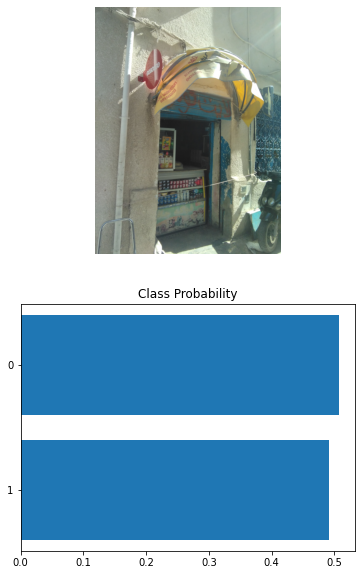

In [ ]:
def view_classify(img_path, prob, classes):
    ''' Function for viewing an image and it's predicted classes.
    '''
    image = Image.open(img_path)
    fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)
    
    
    ax1.imshow(image)
    ax1.axis('off')
    
    y_pos = np.arange(len(prob))
    ax2.barh(y_pos, prob, align='center')
    ax2.set_yticks(y_pos)
    
    ax2.invert_yaxis()  # labels read top-to-bottom
    ax2.set_title('Class Probability')
view_classify(img_path, probs, classes)

In [ ]:
img_paths = ["/content/gdrive/My Drive/ooredoo_cnn/test_1/1549.jpg","/content/gdrive/My Drive/ooredoo_cnn/test_1/1547.jpg","/content/gdrive/My Drive/ooredoo_cnn/test_1/1546.jpg","/content/gdrive/My Drive/ooredoo_cnn/test_1/2584.jpg","/content/gdrive/My Drive/ooredoo_cnn/test_1/2580.jpg","/content/gdrive/My Drive/ooredoo_cnn/test_1/641.jpg"]
                       
img_list = [Image.open(img_path) for img_path in img_paths]

In [ ]:
validation_batch = torch.stack([data_transforms['val'](img).to(device)
                                for img in img_list])

In [ ]:
pred_logits_tensor = model_ft(validation_batch)
pred_logits_tensor

tensor([[ 0.9113, -0.3148],
        [ 1.2351, -1.2976],
        [ 1.6579, -0.3438],
        [ 1.4353, -0.8246],
        [ 1.2421, -0.4819],
        [ 1.1202, -0.6541]], device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
pred_probs

array([[0.77313143, 0.22686858],
       [0.9264035 , 0.07359653],
       [0.88098   , 0.11901999],
       [0.90550333, 0.09449671],
       [0.8486389 , 0.1513611 ],
       [0.854986  , 0.14501397]], dtype=float32)

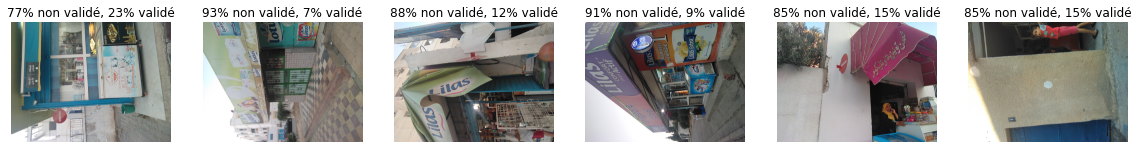

In [ ]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% non validé, {:.0f}% validé".format(100*pred_probs[i,0],
                                                            100*pred_probs[i,1]))
    ax.imshow(img)